In [1]:
from vmod.source import Penny
from vmod.inverse import Inverse
from vmod import util
import numpy as np
import corner
import matplotlib.pyplot as plt

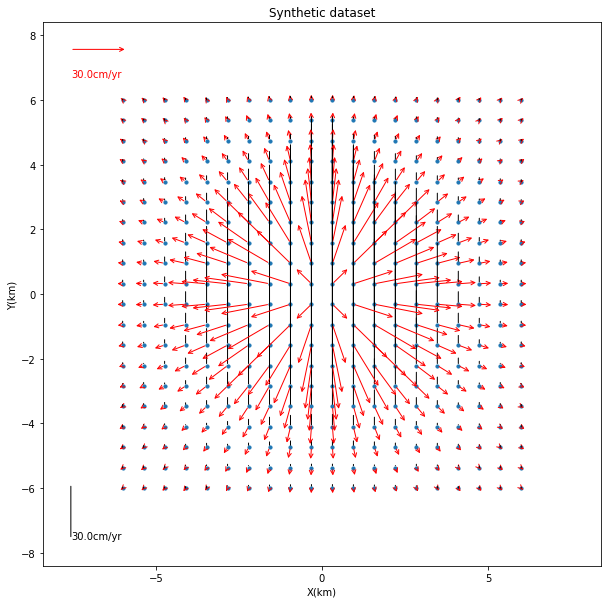

In [2]:
from vmod.data import Gnss

x1=np.linspace(-6000,6000,20)
y1=np.linspace(-6000,6000,20)
X,Y=np.meshgrid(x1,y1)

xgps=X.ravel()
ygps=Y.ravel()

datf = Gnss()
datf.add_xs(xgps)
datf.add_ys(ygps)

#print(dat.ys)

#Penny shaped crack model
penny = Penny(datf)
#Initial parameters [xcen,ycen,depth,pressure(shear),radius]
penny.set_x0(np.array([0, 0, 500, 0.001, 1000]))
#Bounds for parameters [xcen,ycen,depth,pressure(shear),radius]
penny.set_bounds(low_bounds = [-10000, -10000, 0, 0, 0], high_bounds = [10000, 10000, 40000, 0.01, 10000])

inv=Inverse(datf)
inv.register_source(penny)

params=[0, 0, 3000, 0.01, 1000]

datf.add_data(xgps*0,xgps*0,xgps*0)

ux,uy,uz=inv.forward(params,unravel=False)

uxd=ux+np.random.normal(0,np.abs(ux)/4)
uyd=uy+np.random.normal(0,np.abs(uy)/4)
uzd=uz+np.random.normal(0,np.abs(uz)/4)

dat = Gnss()
dat.add_xs(xgps)
dat.add_ys(ygps)

#dat.add_data(uxd,uyd,uzd)
dat.add_data(ux,uy,uz)

util.plot_gnss(xgps,ygps,dat.ux,dat.uy,dat.uz,title='Synthetic dataset',scl=30.0,figsize=(10,10))

In [3]:
from vmod.source import Regdis

reg = Regdis(dat,typ='open',ln=7,wn=7,depth=3e3,length=4e3,width=4e3,lamb=1e-3)
reg.set_x0(0.0)
#Initial parameters [xcen,ycen,depth,length,width,opening,strike,dip]
reg.set_bounds(low_bound = -20, high_bound = 20)

In [4]:
inv=Inverse(dat)
inv.register_source(reg)

In [5]:
ans=inv.nlsq()

0.00015151306823259084


In [6]:
print(ans.x)

[ 0.0211616   0.0211585   0.02115777  0.02115808 -0.10159074 -0.10158122
 -0.10157847 -0.10157969  0.17334672  0.17333415  0.17333093  0.17333484
 -0.10159071 -0.10158156 -0.10157817 -0.10157911  0.41274232  0.41271441
  0.41270181  0.41270547 -0.76158976 -0.76155302 -0.76153844 -0.76154995
  0.17334742  0.17333796  0.17332922  0.17333015 -0.76159308 -0.76156444
 -0.76153341 -0.76153697  4.42121444  4.42117703  4.4211418   4.42115317
 -0.19638932 -0.19637415  0.88228241  0.88223119  8.89563381  8.8956907
 -0.19638692 -0.19637785  0.88227134  0.88224482  8.89564838  8.89567507
 10.09556398]


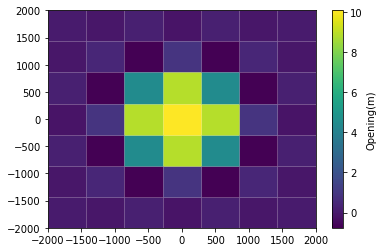

In [7]:
reg.plot_patches(ans.x)

In [5]:
inv.mcmc('regsill')

 [                  0%                  ] 111 of 1100000 complete in 6.0 secHalting at iteration  116  of  1100000


(array([], shape=(4, 0), dtype=float64), <pymc.MCMC.MCMC at 0x7f62d3062970>)

### Synthetic example 2: checkerboard test

3.3065957770095524


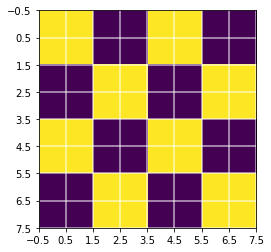

In [1]:
from vmod.inverse import Inverse
from vmod import util
import numpy as np
import corner
import matplotlib.pyplot as plt
from vmod.source import Regdis

def get_lim(arr):
    max_abs_val = abs(arr[0])
    for elem in arr:
        max_abs_val = max(max_abs_val, abs(elem))
    return max_abs_val

from scipy.stats import gaussian_kde
def get_map(xs):
    kde = gaussian_kde(xs)
    x = np.linspace(np.min(xs), np.max(xs), 1000)
    pdf = kde(x)
    map_value = x[np.argmax(pdf)]
    return map_value

# read in an InSAR data class where we can save our synthetic deformation 
from vmod.data import Insar
csvfile_ref = 'examples/insar/tanaga59_ref.csv'
insarobs         = Insar()
insarobs.importcsv(csvfile_ref,ori=[-178.14,51.85])
print(np.mean(insarobs.az)) 

# create a 4-by-4 checkerboard-shaped fault source 
synmat = np.zeros([8,8]) 
synmat[ 0: 2, 0: 2] = 5 
synmat[ 0: 2, 4: 6] = 5 
synmat[ 2: 4, 2: 4] = 5 
synmat[ 2: 4, 6: 8] = 5 
synmat[ 4: 6, 0: 2] = 5 
synmat[ 4: 6, 4: 6] = 5 
synmat[ 6: 8, 2: 4] = 5 
synmat[ 6: 8, 6: 8] = 5 

# plot the synthetic fault and its deformation response 
plt.imshow(synmat)
plt.grid(color='w', linestyle='-', linewidth=2, alpha=0.5)
plt.xticks(np.arange(-0.5, 8, 1));
plt.yticks(np.arange(-0.5, 8, 1)); 

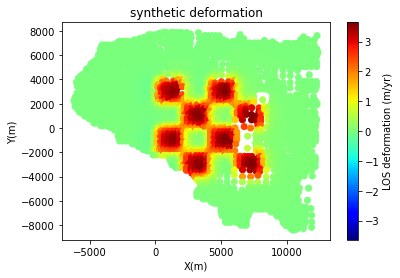

In [2]:
reg = Regdis(insarobs,typ='open',ln=8,wn=8,xcen=4000,depth=500,length=8000,width=8000,lamb=0.000001)
reg.set_x0(0.0)

reg.set_bounds(low_bound = -20, high_bound = 20)

inv=Inverse(insarobs)
inv.register_source(reg)

synmat_regdis_array = reg.transform_order_natural2regdis( synmat.flatten() )
fwd = inv.forward(synmat_regdis_array,unravel=False)

plt.figure()
plt.title('synthetic deformation')
data = fwd[0]
plt.scatter( insarobs.xs,insarobs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')
plt.show() 

In [2]:
# run the inversion
# def set_numsteps(self,steps,burnin,thin):
# default is steps=6`600`000, burnin=600`000, thin=1`000
inv.set_numsteps(1000000,10000,100) 

trace,MDL = inv.mcmc('regsill_checker') 

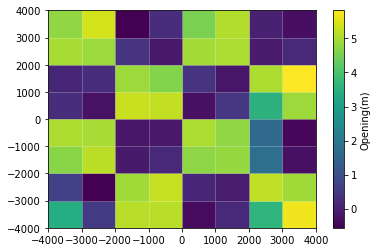

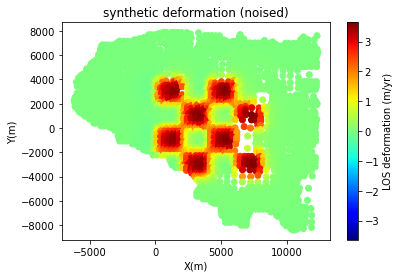

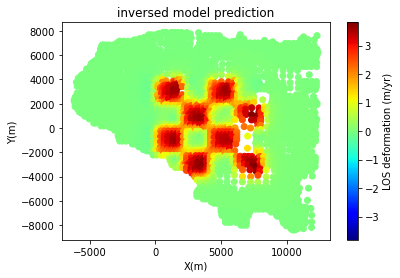

In [3]:
import pickle
with open('regsill_checker.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

iopsmean = np.zeros(( np.shape(trace)[0] ,  ))
for i in range(np.shape(trace)[0] ):
    iopsmean[i] = ( np.mean(trace[i]) )

iopsmap = np.zeros(( np.shape(trace)[0] ,  ))
for i in range(np.shape(trace)[0] ):
    iopsmap[i] = ( get_map(trace[i]) )
    
reg.plot_patches(iopsmap) # or plt.imshow( reg.transform_order_regdis2natural(iopsmap).reshape(ln,wn) )

plt.figure()
plt.title('synthetic deformation (noised)')
data = fwd[0]
plt.scatter( insarobs.xs,insarobs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')
plt.show()

inv=Inverse(insarobs)
oks,params = reg.get_reg_sill(iopsmap)
for ok in oks:
    inv.register_source(ok)
fwd = inv.forward(params,unravel=False)
plt.figure()
plt.title('inversed model prediction')
data = fwd[0]
plt.scatter( insarobs.xs,insarobs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')
plt.show()